In [1]:
import numpy as np
import mne
import pyedflib
from pyedflib import highlevel
from datetime import datetime

In [7]:
filename = './data/A01_SE001CB_Train01.edf'
raw_data = mne.io.read_raw_edf(filename, verbose=None) # read data
raw_data.load_data() # load data

Extracting EDF parameters from /Users/zionshane/Desktop/Duke/Research/P300-BCI/P300-BCI/Others/MNE-training/mne_tutorial/data/A01_SE001CB_Train01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 35207  =      0.000 ...   137.527 secs...


<RawEDF | A01_SE001CB_Train01.edf, 114 x 35208 (137.5 s), ~30.7 MB, data loaded>

In [35]:
raw_data.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG_F3, EEG_Fz, EEG_F4, EEG_T7, EEG_C3, EEG_Cz, EEG_C4, EEG_T8, ...
 chs: 114 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 30.0 Hz
 meas_date: 2020-01-01 00:00:00 UTC
 nchan: 114
 projs: []
 sfreq: 256.0 Hz
>

In [4]:
eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], 'EEG')
raw_data.notch_filter(freqs=60, picks=eeg_channels)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


<RawEDF | A01_SE001CB_Train01.edf, 114 x 35208 (137.5 s), ~30.7 MB, data loaded>

## So what is a STIM channel?

A stim channel (short for “stimulus channel”) is a channel that does not receive signals from an EEG, MEG, or other sensor. Instead, STIM channels record voltages that are time-locked to experimental events, such as the onset of a stimulus or a button-press response by the subject (those pulses are sometimes called TTL pulses, event pulses, trigger signals, or just “triggers”). In other cases, these pulses may **not be strictly** time-locked to an experimental event, but instead may occur in between trials to indicate the type of stimulus (or experimental condition) that is about to occur on the upcoming trial.

If your data has events recorded on a STIM channel, you can convert them into an events array using `find_events`. The sample number of the onset (or offset) of each pulse is recorded as **the event time**, the pulse magnitudes (**event**) are converted into integers, and these pairs of sample numbers with integer codes are stored in `NumPy arrays` (usually called “the events array” or just “the events”). In its simplest form, the function requires only the `Raw` object, and the name of the channel(s) from which to read events.

`find_events()` returns a `Numpy.array` with 3 columns. The first column contains the event time in samples. The third column contains the event id. In between the sample number and the integer event code is a value indicating what the event code was on the immediately preceding sample. In practice, that value is almost always 0.

In [11]:
## Spelling Outcomes
current_target_events   = mne.find_events(raw_data, stim_channel='CurrentTarget',
                                          verbose=False)
predicted_target_events = mne.find_events(raw_data, stim_channel='SelectedTarget',
                                          verbose=False)
current_target   = current_target_events[:,2] # event ids
predicted_target = predicted_target_events[:,2]

`Epochs` objects are a data structure for representing and analyzing **equal-duration chunks of the EEG/MEG signal**. `Epochs` are most often used to represent data that is time-locked to repeated experimental events (such as stimulus onsets or subject button presses). Inside an `Epochs` object, the data are stored in an array of shape `(n_epochs, n_channels, n_times)`.

In [64]:
current_target_events

array([[ 1160,     0,     4],
       [ 5896,     0,    18],
       [10632,     0,     9],
       [15368,     0,    22],
       [20104,     0,     9],
       [24840,     0,    14],
       [29576,     0,     7]])

In [30]:
## Extract EEG Epochs (see https://mne.tools/stable/auto_tutorials/epochs/index.html)
# Find stimulus events and target stimulus events
stim_events     = mne.find_events(raw=raw_data, stim_channel='StimulusBegin',
                                  verbose=False)
targstim_events = mne.find_events(raw=raw_data, stim_channel='StimulusType',
                                  verbose=False)
# Label target (event_id = 1) and non-target (event_id = 0) events
# Note that the event_id is stored in the third column in events array
targstim_indices = np.isin(stim_events[:,0], targstim_events[:,0])
stim_events[~targstim_indices,2] = stim_events[~targstim_indices,2] - 1
# Epoch data based on target and non-target epoch labels
t_min,t_max = 0, 0.8 # feature extraction window
event_dict = {'target': 1, 'non_target': 0} # stimulus event label -> event_id
epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                    event_id=event_dict, preload=True, baseline=None,
                    proj=False, picks=eeg_channels)

Not setting metadata
840 matching events found
No baseline correction applied
Using data from preloaded Raw for 840 events and 206 original time points ...
0 bad epochs dropped


In [55]:
epochs

Number of events,840
Events,non_target: 770target: 70
Time range,0.000 – 0.801 s
Baseline,off


In [ ]:
channel_pick = raw_data.ch_names[5] # EEG_CZ
epochs.plot(picks=channel_pick, n_epochs=10, events=True)

Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_2700/610563694.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['target'].plot_image(picks=channel_pick,


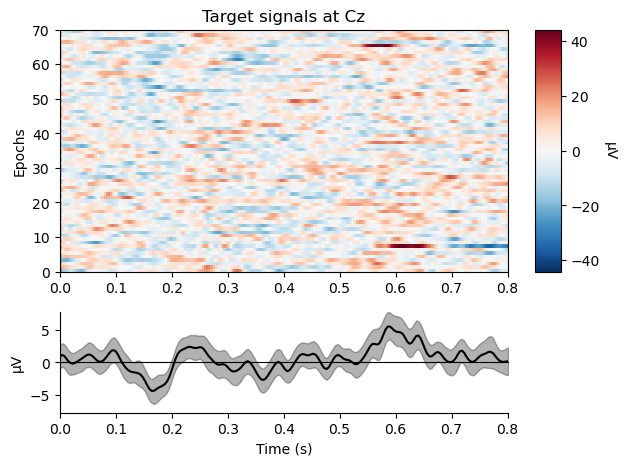

[<Figure size 640x480 with 3 Axes>]

In [67]:
# Plot target signals at a specific channel
epochs['target'].plot_image(picks=channel_pick,
                            title='Target signals at '+channel_pick[4:])

Not setting metadata
770 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_2700/3887258469.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['non_target'].plot_image(picks=channel_pick,


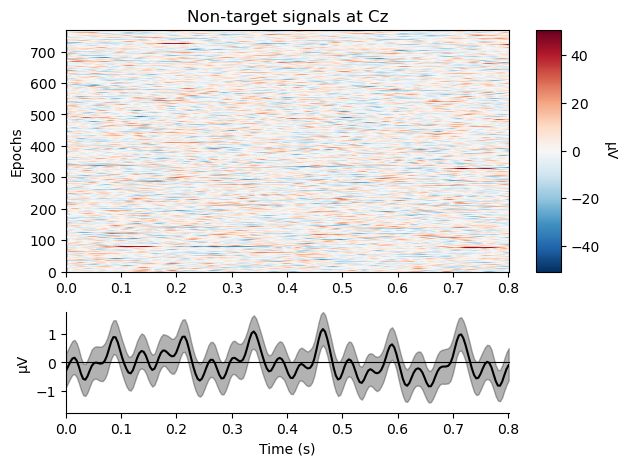

[<Figure size 640x480 with 3 Axes>]

In [68]:
# Plot non-target signals at a specific channel
epochs['non_target'].plot_image(picks=channel_pick,
                                title='Non-target signals at '+channel_pick[4:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


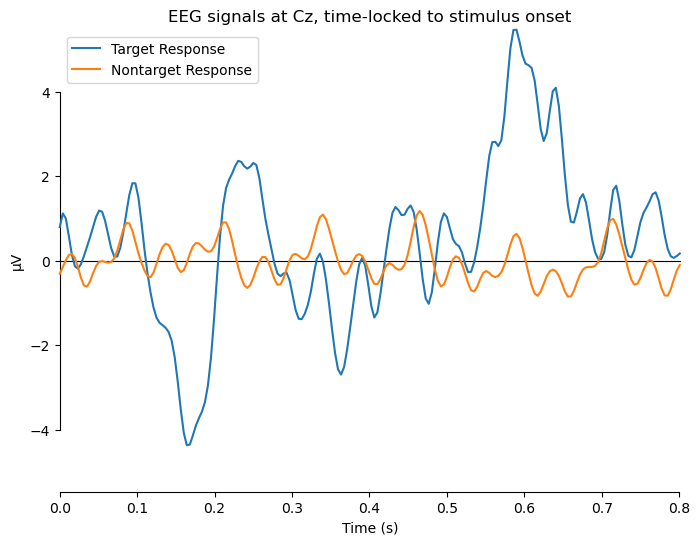

[<Figure size 800x600 with 1 Axes>]

In [69]:
# Alternate visualisation: Average target and nontarget signals
erp_target = epochs['target'].average()
erp_nontarget = epochs['non_target'].average()
figure_title = 'EEG signals at '+channel_pick[4:]+', time-locked to stimulus onset'
mne.viz.plot_compare_evokeds(evokeds={'Target Response': erp_target,
                                      'Nontarget Response': erp_nontarget},
                             picks=channel_pick,
                             show_sensors=False,
                             title=figure_title)

In [63]:
## Stimulus Presentation Schedule
character_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], '.*_\d*_\d*$')

In [60]:
## Demographics
file_header = highlevel.read_edf_header('./data/A01_SE001CB_Train01.edf')
sex = file_header['gender'] # Sex
other_demo = file_header['patientname'] # Race_Ethnicity_ALSFRS score
birth_date = datetime.strptime(file_header['birthdate'], '%d %b %Y')
start_date = file_header['startdate']
age = (start_date - birth_date).days//365 # Age in years